# Leitura dos dados

In [132]:
# carregando algumas bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

# lendo os dados de teste
file_path = '/content/drive/MyDrive/air_system_previous_years.csv'
X = pd.read_csv(file_path, na_values='na')

# Verificando se todas as colunas que não a class são numéricas
X.select_dtypes(include=['number']).shape # as 170 outras colunas são de fato numéricas

from sklearn.preprocessing import LabelEncoder
X['class'] = X['class'].astype('category')
label_encoder = LabelEncoder()
X['class'] = label_encoder.fit_transform(X['class'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Seleção de variáveis

Vamos selecionar as variáveis de duas formas. Primeiro, vamos remover aquelas em que o valor mais frequente aparece muito mais que o segundo valor mais frequente, e que, ao mesmo tempo, tenha uma quantidade de valores únicos dividida pela quantidade total de valores muito baixa. Os valores definidos aqui foram os mesmos que estão implementados por default na função nearZeroVar do pacote Caret implementado por Max Kuhn no R, isto é, razão entre os valores frequentes deve maior ou igual a 19, e porcentagem de valores únicos menor ou igual que 10% para a variável ser removida.

In [133]:
results = pd.DataFrame(columns=['Column', 'Unique_Ratio', 'Top1_Top2_Ratio'])

def calculate_metrics(column):
    col_no_na = column.dropna()
    total_elements = len(col_no_na)

    if total_elements == 0:
        return (0, 0)

    unique_ratio = col_no_na.nunique() / total_elements
    value_counts = col_no_na.value_counts()

    if len(value_counts) < 2:
        top1_top2_ratio = np.nan # importante remover esses casos também
    else:
        # razão entre o valor mais frequente e o segundo mais frequente
        top1_top2_ratio = value_counts.iloc[0] / value_counts.iloc[1]

    return (unique_ratio, top1_top2_ratio)

for col in X.columns[1:]: # sem usar a coluna de classe
    unique_ratio, top1_top2_ratio = calculate_metrics(X[col])
    result = pd.DataFrame({
        'Column': [col],
        'Unique_Ratio': [unique_ratio],
        'Top1_Top2_Ratio': [top1_top2_ratio]
    })
    results = pd.concat([results, result], ignore_index=True)

In [134]:
filtered_results = results[(results['Unique_Ratio'] <= 0.1005) & ((results['Top1_Top2_Ratio'] >= 19) | results['Top1_Top2_Ratio'].isna())]
filtered_results.shape

(44, 3)

Teremos estão 44 variáveis removidas

In [135]:
X=X.drop(columns = filtered_results['Column'])

In [136]:
X.shape

(60000, 127)

Agora vamos remover as variáveis que tenham muitos valores NA. Nesse caso, uma taxa de valores NA maior que 10% já serão removidas.

In [137]:
threshold = len(X)*0.9
X.dropna(axis=1, thresh=threshold).shape
X = X.dropna(axis=1, thresh=threshold)

In [138]:
X.shape

(60000, 105)

Ficamos então com 105 variáveis, podemos partir agora para a imputação dos dados

## Imputação dos dados

Sem informações a respeito do significado das variáveis é difícil fazer imputação dos dados. Assim, uma primeira tentativa poderia ser a de remover as observações que possuirem pelo menos uma variável sem informação, mas fazendo assim verificamos que os grupos, que ja eram desbalanceados, ficaram mais desbalanceados ainda. Antes, a proporção de negativos para cada positivo era de 59, e agora passou a ser de 132.78. Como quase todas as colunas apresentam valor NA, teremos que fazer imputação, caso contrário teriamos que utilizar apenas métodos que suportem valores faltantes.

Como os dados estão relacionados com o grupo a que pertencem, podemos utilizar alguns métodos. Por exemplo, poderiamos fazer uma média da variável para cada grupo e colocar esse valor nas observações faltantes. Nesse caso, como a natureza das variáveis é desconhecida, irei utilizar KNN para imputação, assim, segue que:

In [142]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=10)
completos = imputer.fit_transform(X)
df_completos = pd.DataFrame(completos, columns=X.columns, index=X.index)

In [143]:
X_train = df_completos.iloc[:, 1:]
y_train = df_completos.iloc[:, 0]

# Proposta de métricas a serem utilizadas

## Métricas técnicas

Conforme descrito no problema, se adotarmos como hipótese nula que o ônibus não precisa de manutenção, o custo relacionado ao erro do tipo 1, ou seja, dizer que o ônibus está com defeito quando na realidade ele não está, é de \$10. Por outro lado, o custo do erro do tipo 2, isso é, considerar que o ônibus está bom quando na realidade precisa de reparo, é de \$500. Dessa forma, uma métrica que devemos utilizar para medir a qualidade do modelo é a sensibilidade, já que, como é impossível acertar em todos os casos, é preferível mandar para conserto um ônibus em perfeito estado, do que deixar circulando um ônibus que precisa de reparo. Nesse contexto, faz sentido utilizarmos também o coeficiente de Kappa e a e área sob a curva ROC para um bom trade-off entre sensitividade e sensibilidade.

## Métricas de negócio

Algumas business metrics poderiam ser

- Taxa de caminhões em reparo, medida como o total de caminhões levados para reparo dividido pelo total de caminhões que apresentaram defeito. Importante para vermos se estão sendo mandados muitos caminhões além do necessário.

- Taxa de falha, definida como a quantidade total de caminhões corretamente classificados como defeituosos dividido pela quantidade total de caminhões defeituosos. Uma boa métrica para se saber o quanto estamos cometende de erro do tipo 2.

- Eficiência do dinheiro, calculada como a razão entre o mínimo de dinheiro que precisava ser gasto e o dinheiro realmente gasto. Como o nome diz, é uma boa métrica para sabermos o qual eficaz foi nosso gasto.

Todas métricas estão interligadas, mas explicam fenômenos diferentes. Elas podem ser usadas conjuntamente para definir quando o modelo, depois de implantado, deve ser treinado novamente.



# Implementando modelos

Escolhi 3 modelos para testar, pensando sempre em desempenho e alguma interpretabilidade. Assim, usarei Random Forest, Regressão logística e XGBoost

## Random Forest

In [145]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Aqui a importância das variáveis é com base no impacto da variável na impureza de um nó, ou seja, com base no Gini.

In [146]:
importancias = rf_model.feature_importances_
importancias_df = pd.DataFrame(importancias, index=X_train.columns, columns=['Importancia'])
importancias_df.sort_values(by='Importancia', ascending=False, inplace=True)
print(importancias_df.head(6))

        Importancia
bj_000     0.054895
am_0       0.034851
al_000     0.033133
ag_003     0.032967
aq_000     0.031065
ci_000     0.030434


## Regressão Logística


In [ ]:
import statsmodels.api as sm
X_train_lr = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_lr)
result = logit_model.fit()

In [148]:
p_valores = result.pvalues
p_valors_df = pd.DataFrame({'Variavel': X_train_lr.columns, 'Valor_p': p_valores})
p_valors_df.sort_values(by='Valor_p').head(6)

,Variavel,Valor_p
const,const,0.000000e+00
bs_000,bs_000,7.856159e-39
cb_000,cb_000,9.428761e-17
ag_003,ag_003,5.030374e-09
eb_000,eb_000,6.301463e-09
cj_000,cj_000,6.377352e-09


Aqui para tentar dizer quais variáveis foram mais importantes, usei o p-valor como critério. Assim, as variáveis que rejeitaram a hipótese de que seu coeficiente vale 0 com maior confiança, são as mais importantes.

## XGboost

Um modelo inicial poderia ser o abaixo.

In [152]:
import xgboost as xgb
xgbTreino = xgb.DMatrix(X_train, y_train, enable_categorical=True)
xgboost_treino = xgb.XGBClassifier(
    objective = 'binary:logistic',
    missing = np.NaN,
    seed = 42  ,
    eval_metric = 'auc'
)

xgboost_treino.fit(
    X_train,
    y_train,
    verbose = True
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Agora, vamos fazer uma seleção dos hiperparâmetros. Por exemplo, a taxa de aprendizado, a profundidade máxima e os pesos atribuidos a cada grupo. Esse último parâmetro é especialmente importante pois os grupos são muito desbalanceados.

Repare também que a métrica para escolher os melhores parâmetros foi o recall,pois o problema foi muito claro no quesito de qual erro é mais impactante nesse contexto.

In [153]:
from sklearn.model_selection import GridSearchCV
params_grid = {
    'max_depth': [25, 50, 75],
    'learning_rate': [0.01, 0.1],
    'gamma': [0.1, 1],
    'reg_lambda': [1, 10],
    'scale_pos_weight': [30, 60] # pelo fato dos grupos serem muito desbalanceados
}

otimizados = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                  missing = np.NaN,
                                  subsample = 0.6,
                                  colsample_bytree = 0.5),
    param_grid = params_grid,
    scoring = 'recall',
    cv = 3,
    n_jobs = -1
)

otimizados.fit(
    X_train,
    y_train,
    verbose = True
)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.1, 1], 'learning_rate': [0.01, 0.1],
                         'max_depth': [25, 50, 75], 'reg_lambda': [1, 10],
                         'scale_pos_weight': [30, 60]},
             scoring='recall')

Esses foram os parâmetros escolhidos

In [154]:
otimizados.best_params_

{'gamma': 1,
 'learning_rate': 0.01,
 'max_depth': 25,
 'reg_lambda': 10,
 'scale_pos_weight': 60}

Como alguns dos hiperparâmetros otimizados foram o máximo ou mínimo das opções listadas, irei realizar outra validação cruzada

In [155]:
params_grid2 = {
    'max_depth': [15, 25],
    'learning_rate': [0.01,.005],
    'gamma': [1, 5],
    'reg_lambda': [10, 15, 20],
    'scale_pos_weight': [60] # pelo fato dos grupos serem muito desbalanceados
}

otimizados2 = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                  missing = np.NaN,
                                  subsample = 0.6,
                                  colsample_bytree = 0.5),
    param_grid = params_grid2,
    scoring = 'recall',
    cv = 3,
    n_jobs = -1
)

otimizados2.fit(
    X_train,
    y_train,
    verbose = True
)

otimizados2.best_params_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'gamma': 5,
 'learning_rate': 0.005,
 'max_depth': 25,
 'reg_lambda': 20,
 'scale_pos_weight': 60}

Houveram algumas mudanças, vamos fazer um processo análogo novamente



In [156]:
params_grid3 = {
    'max_depth': [25],
    'learning_rate': [0.001,.005],
    'gamma': [5,10],
    'reg_lambda': [20, 30, 40],
    'scale_pos_weight': [60] # pelo fato dos grupos serem muito desbalanceados
}

otimizados3 = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                  missing = np.NaN,
                                  subsample = 0.6,
                                  colsample_bytree = 0.5),
    param_grid = params_grid3,
    scoring = 'recall',
    cv = 3,
    n_jobs = -1
)

otimizados3.fit(
    X_train,
    y_train,
    verbose = True
)

otimizados3.best_params_

{'gamma': 5,
 'learning_rate': 0.001,
 'max_depth': 25,
 'reg_lambda': 40,
 'scale_pos_weight': 60}

Novamente

In [165]:
params_grid4 = {
    'max_depth': [25],
    'learning_rate': [0.001,.0005],
    'gamma': [5],
    'reg_lambda': [40,60,80],
    'scale_pos_weight': [60] # pelo fato dos grupos serem muito desbalanceados
}

otimizados4 = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                  missing = np.NaN,
                                  subsample = 0.6,
                                  colsample_bytree = 0.5),
    param_grid = params_grid4,
    scoring = 'recall',
    cv = 3,
    n_jobs = -1
)

otimizados4.fit(
    X_train,
    y_train,
    verbose = True
)

otimizados4.best_params_

{'gamma': 5,
 'learning_rate': 0.0005,
 'max_depth': 25,
 'reg_lambda': 80,
 'scale_pos_weight': 60}

Ótimo! Já temos os hiperparâmetros para o XGBoost.

In [173]:
parametros = otimizados4.best_params_

xgboost_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    missing = np.NaN,
    seed = 42,
    eval_metric = 'auc',
    **parametros
)

xgboost_model.fit(
    X_train,
    y_train,
    verbose = True
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

As variáveis mais importantes aqui também serão escolhidas conforme o impacto na pureza dos nós, logo:

In [178]:
importanciasxg = xgboost_model.feature_importances_
importanciasxg_df = pd.DataFrame(importanciasxg, index=X_train.columns, columns=['Importancia'])
importanciasxg_df.sort_values(by='Importancia', ascending=False, inplace=True)
print(importanciasxg_df.head(6))

        Importancia
ck_000     0.833355
ba_002     0.059532
am_0       0.020650
ci_000     0.019508
bc_000     0.008183
az_000     0.005868


# Testando os modelos

Primeiro, vamos ler os dados de teste, isto é, os dados atuais, e manter apenas as colunas que foram selecionadas nos dados de treino

In [159]:
file_path = '/content/drive/MyDrive/air_system_present_year.csv'
dados_atuais = pd.read_csv(file_path, na_values='na')
codificador = LabelEncoder()
dados_atuais['class'] = codificador.fit_transform(dados_atuais['class'])
colunas_selecionadas = ['class'] + list(X_train.columns)
dados_atuais = dados_atuais[colunas_selecionadas]
dados_atuais.shape
verificar = dados_atuais

E vamos completar os dados com KNN novamente

In [160]:
imputer_test = KNNImputer(n_neighbors=10)
completos_test = imputer_test.fit_transform(dados_atuais)
dados_atuais = pd.DataFrame(completos_test, columns=dados_atuais.columns, index=dados_atuais.index)

Agora, basta criar os dados de teste em variáveis próprias

In [161]:
X_test = dados_atuais.iloc[:, 1:]
y_test = dados_atuais.iloc[:, 0]


## Testando Random Forest

In [162]:
from sklearn.metrics import confusion_matrix, classification_report
rf_y_pred = rf_model.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
rf_conf_matrix

array([[15603,    22],
       [  114,   261]])

## Testando Regressão Logística

In [163]:
X_test_lr = sm.add_constant(X_test)
lr_y_pred = result.predict(X_test_lr)
lr_y_pred = (lr_y_pred >= .5).astype(int)
lr_conf_matrix = confusion_matrix(y_test, lr_y_pred)
lr_conf_matrix

array([[15573,    52],
       [  119,   256]])

## Testando XGBoost

In [175]:
xg_y_pred = xgboost_model.predict(X_test)
xg_conf_matrix = confusion_matrix(y_test, xg_y_pred)
xg_conf_matrix

array([[14884,   741],
       [   13,   362]])

## Comparando os modelos


Pela importância de cada métrica, escolhemos como modelo o XGBoost, já que, em comparação com o random forest e regressão logística, ele errou muito menos em aprovar caminhões que tinham defeito, mesmo que ao custo de reprovar mais caminhões em bom estado. Assim, se tivessemos usado o random forest, teriamos um custo de 261\*25 + 22 * 10 + 114\*500 = 63745 dólares, usando regressão logística 119\*500 + 52\*10 + 256\*25 = 66420, enquanto que usando XGBoost, teriamos um custo de 362\*25 + 741\*10 + 13\*500 = 22960 dólares, ou seja, uma economia de 40785 dólares com relação ao segundo melhor modelo.

Se ao invés de usar modelos nós apenas sortearmos o grupo ao qual cada observação pertence de forma independente e com probabilidade 375/16000 de pertencer ao grupo positivo, e probabilidade 15625/16000 de pertencer ao grupo negativo (ou seja, probabilidades proporcionais aos tamanhos dos grupos), então o valor esperado do custo é:

((375/16000)^2\*25 + (15625/16000)\*(375/16000)\*500 + (15625/16000)\*(375/16000)\*10)\*16000 = \$186987.30

Dessa forma, usarmos o modelo de XGBoost ao invés de sortear quais caminhões devem ser inspecionados traz uma economia de \$164027.3.

Por fim, vamos analisar a relação do custo do modelo com a métrica de negócios proposta anteriormente. O custo mínimo seria de 375\*25 = 9325, então o XGBoost é \$13635 mais caro do que o necessário. Interessante notar que essa possível economia é bem menor que a diferença entre o modelo de XGBoost e o de Random Forest, mostrando a qualidade do ajuste desse primeiro.


Nesse caso, a taxa de caminhões em reparo é de 1103/375 = 2.91, indicando que foram levados para reparo cerca de 3 vezes mais caminhões do que necessário. Além disso, a taxa de falha foi de 362/375 = 0.965, e a eficiência do dinheiro foi de 9325/22960 = 0.4

# Visualizando a importância das variáveis

O modelo XGBoost selecionou como mais importante a variável ck_000, assim:

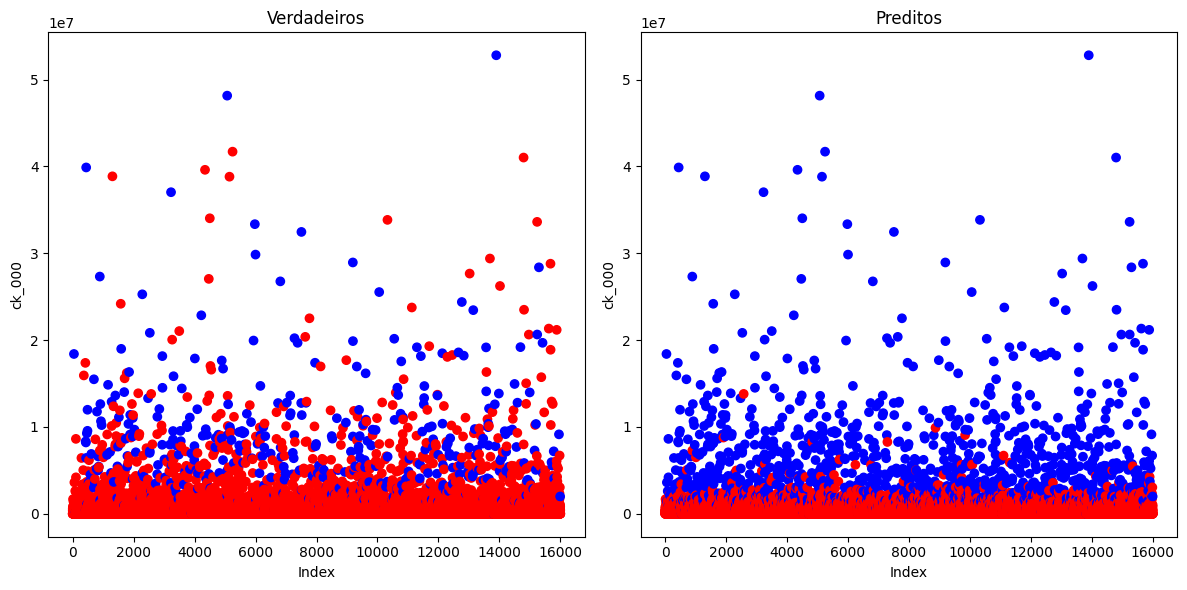

In [179]:
from matplotlib.colors import ListedColormap
cores = np.array(['red', 'blue'])
colormap = ListedColormap(cores)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scatter1 = axs[0].scatter(x=range(0, X_test.shape[0]), y=X_test['ck_000'], c=y_test, cmap=colormap)
axs[0].set_xlabel('Index')
axs[0].set_ylabel('ck_000')
axs[0].set_title('Verdadeiros')

scatter2 = axs[1].scatter(x=range(0, X_test.shape[0]), y=X_test['ck_000'], c=xg_y_pred, cmap=colormap)
axs[1].set_xlabel('Index')
axs[1].set_ylabel('ck_000')
axs[1].set_title('Preditos')


# Ajustar o layout para melhor visualização
plt.tight_layout()

# Mostrar os gráficos
plt.show()

Podemos notar que o modelo XGBoost colocou os valores "altos" de 'ck_000' como pertencentes ao grupo de azul (positivo), e os valores "baixos" como pertencentes ao grupo vermelho (negativo). Isso pode ser verificado na tabela abaixo. Interessante notar também que muitos pontos que eram para ser vermelhos foram colocados no grupo azul, mas o inverso não é fácil de ver acontecer, isso é esperado devido à importância do racall na avaliação do modelo.

In [180]:
new_df = (
    dados_atuais.groupby('class')['ck_000'].agg(['mean', 'std'])
    .set_axis(['media', 'desvio padrao'], axis=1)
    .reset_index()
)
new_df

,class,media,desvio padrao
0,0.0,5.722087e+05,1.676038e+06
1,1.0,8.560394e+06,6.935785e+06


Podemos notar que ambos em termos de média e desvio padrão os grupos são de fato bem diferentes

# Considerações

Antes de fazer o deploy desse modelo, é importante verificar algumas coisas:


1.   De que forma foram coletados os dados?
2.   Os dados continuaram sendo coletados dessa mesma maneira no futuro?
3.   Temos como melhorar ainda mais a escolha dos hiperparâmetros?
4.   Temos multicolinearidade nos dados afetando a regressão logística, por exemplo?
5.   Podemos selecionar variáveis de outras maneiras? Nesse caso, removi apenas as com muitas observações faltantes ou pouca variabilidade, mas poderiamos selecionar também por significância, por exemplo? Ou existem variáveis que mesmo não significarivas devem ser mantidas no modelo?
6.   A literatura indica algum modelo geralmente melhor nesses casos? Se sim, devemos testa-lo tambem

